# Libraries

In [1]:
import numpy as np
import pandas as pd
from wordcloud import STOPWORDS
import spacy, nltk
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
from nltk.corpus import PlaintextCorpusReader
from gensim.models import LdaMulticore
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Loading

In [2]:
ba_reviews_experts_en = pd.read_parquet('../generated/ba_reviews_experts_en.parquet')[['user_id', 'text']]
rb_reviews_experts_en = pd.read_parquet('../generated/rb_reviews_experts_en.parquet')[['user_id', 'text']]

In [2]:
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
stopwords = set(STOPWORDS)
stopwords.update(spacy_stopwords)
stopwords.update(['beer', 'beers'])
NUM_TOPIC = 10

# Dataset Construction for Topic Detection

To ensure a robust and balanced dataset for topic detection, we implemented an iterative and user-balanced approach for constructing ba_reviews_experts.txt and rb_reviews_experts.txt. This method iteratively selects reviews from each user in the dataset until a target number of sentences **(10,000 x 50 = 500,000 sentences)** is reached.

This approach ensures that the datasets used for topic detection are:
- Representative of the full range of users and their contributions.
- Balanced to avoid over-representation of highly prolific users.
- Optimized for topic modeling, as it captures a wide variety of vocabulary and themes while meeting the required size.

## Why This Method?

1. Avoids Prolific User Bias:
   - By iterating over all users and selecting reviews evenly, this method ensures a fair representation of users in the dataset.
2. Captures a Diverse Vocabulary:
   - Each user may focus on different aspects of beers (e.g., taste, aroma, appearance). This method ensures that the dataset includes a variety of styles and perspectives, which enriches the topics detected.
3. Maintains Balance Across Platforms:
   - The same logic is applied to both BeerAdvocate and RateBeer, ensuring that the topic detection results are comparable across platforms.
4. Targets a Specific Number of Sentences:
   - The method systematically aggregates reviews until the required number of sentences is reached, ensuring datasets of equal size for both platforms.
5. Avoids Temporal or Structural Bias:
   - Reviews are not taken sequentially or randomly. Instead, reviews are evenly distributed across users, reducing the risk of introducing biases from review order or submission date.
  
This iterative and user-balanced method significantly improves the representativity, diversity, and balance of the datasets compared to simpler methods (e.g., taking the first 100,000 sentences). This improvement lays a solid foundation for generating reliable and insightful topics in the subsequent LDA analysis.

In [6]:
limit = 10000 # how many chunks total
size = 50 # how many sentences per chunk/page
target_total_sentences = limit * size # how many sentences total

In [6]:
df_ba_current_total_reviews = pd.DataFrame(columns= ba_reviews_experts_en.columns)
max_iter = max(ba_reviews_experts_en.groupby('user_id').agg(number_reviews= 
                                                 ('text', 'count')).reset_index().sort_values(by= 'number_reviews', ascending= False).number_reviews)
ba_current_total_sentences = 0
iteration = 13 * 5 #as 13 iter represent approximately 100_000 sentences for BeerAdvocateExperts

while ba_current_total_sentences < target_total_sentences:
    for user in ba_reviews_experts_en['user_id'].unique():
        df_ba_current_total_reviews = pd.concat([df_ba_current_total_reviews, 
                                                ba_reviews_experts_en[ba_reviews_experts_en['user_id'] == user].head(iteration)])
    ba_current_total_reviews = " ".join(review for review in df_ba_current_total_reviews.text)
    ba_current_total_sentences = len(sent_tokenize(ba_current_total_reviews))
    print(f"Iteration n°{iteration}")
    print(f"BA current total sentences: {ba_current_total_sentences}")
    df_ba_current_total_reviews = pd.DataFrame(columns= ba_reviews_experts_en.columns)
    if iteration > max_iter:
        print("Not enough sentences to reach the target_total_sentences")
        break
    iteration+= 1
output_file = "../generated/corpus/ba_reviews_experts.txt"
with open(output_file, "w", encoding="utf-8") as file:
    file.write(ba_current_total_reviews)
print(f"Le fichier a été sauvegardé sous le nom '{output_file}'.")

Iteration n°65
BA current total sentences: 479554
Iteration n°66
BA current total sentences: 487048
Iteration n°67
BA current total sentences: 494253
Iteration n°68
BA current total sentences: 501437
Le fichier a été sauvegardé sous le nom '../generated/corpus/ba_reviews_experts.txt'.


In [5]:
df_rb_current_total_reviews = pd.DataFrame(columns= rb_reviews_experts_en.columns)
max_iter = max(rb_reviews_experts_en.groupby('user_id').agg(number_reviews= 
                                                 ('text', 'count')).reset_index().sort_values(by= 'number_reviews', ascending= False).number_reviews)
rb_current_total_sentences = 0
iteration = 32 * 5 #as 32 iter represent approximately 100_000 sentences for RateBeerExperts

while rb_current_total_sentences < target_total_sentences:
    for user in rb_reviews_experts_en['user_id'].unique():
        df_rb_current_total_reviews = pd.concat([df_rb_current_total_reviews, 
                                                rb_reviews_experts_en[rb_reviews_experts_en['user_id'] == user].head(iteration)])
    rb_current_total_reviews = " ".join(review for review in df_rb_current_total_reviews.text)
    rb_current_total_sentences = len(sent_tokenize(rb_current_total_reviews))
    print(f"Iteration n°{iteration}")
    print(f"RB current total sentences: {rb_current_total_sentences}")
    df_rb_current_total_reviews = pd.DataFrame(columns= rb_reviews_experts_en.columns)
    if iteration > max_iter:
        print("Not enough sentences to reach the target_total_sentences")
        break
    iteration+= 1
output_file = "../generated/corpus/rb_reviews_experts.txt"
with open(output_file, "w", encoding="utf-8") as file:
    file.write(rb_current_total_reviews)
print(f"Le fichier a été sauvegardé sous le nom '{output_file}'.")

Iteration n°160
BA current total sentences: 498500
Iteration n°161
BA current total sentences: 501646
Le fichier a été sauvegardé sous le nom '../generated/corpus/rb_reviews_experts.txt'.


# 2nd: Advanced Topic Detection Using LDA

## From Naive to Structured Topic Analysis

In the previous section, we explored the datasets using WordClouds, a naive yet effective way to visualize the most frequent words. This approach gave us a high-level overview of the dominant vocabulary in BeerAdvocate and RateBeer reviews.

However, WordClouds only capture word frequency without accounting for:
- The co-occurrence of words (how words group together to form themes).
- The latent structure or topics that reviewers naturally discuss.

To go beyond this naive approach and uncover the hidden themes in the reviews, with the newly constructed, balanced datasets, we now proceed to Latent Dirichlet Allocation (LDA) to uncover the key themes present in BeerAdvocate and RateBeer expert reviews.

## Why LDA?

LDA is a powerful method because it:
- Automatically identifies topics in a corpus based on word co-occurrences.
- Represents each "document" (here, a chunk of reviews) as a mixture of topics.
- Groups together words that frequently appear in similar contexts to reveal latent themes.

Unlike WordClouds, which simply count word occurrences, LDA provides a structured view of the text by detecting patterns and grouping words into coherent topics.

## How It Works
Text Segmentation:
- Each dataset (BeerAdvocate and RateBeer) is split into smaller chunks of about 50 sentences.
- These chunks act as "documents" for the LDA model.

Text Preprocessing:
- Stopwords, punctuation, and irrelevant tokens are removed.
- Words are lemmatized to group different forms of the same word (e.g., "flavors" → "flavor").
- Named Entities (like locations or brands) and bigrams (word pairs like "dark chocolate") are included to improve topic quality.

LDA Topic Modeling:
- The combined chunks from both platforms are processed using LDA.
- LDA outputs a specified number of topics (e.g., 4 topics), where each topic is represented by a set of words with different weights.

Linking Topics to Datasets:
- Each chunk is assigned a dominant topic (the one with the highest probability).
- Using the source of each chunk (BeerAdvocate or RateBeer), we analyze which topics dominate each platform.

## What This Method Will Reveal

1. The key topics discussed in BeerAdvocate and RateBeer reviews.
2. The focus of each platform:
   - Does BeerAdvocate emphasize sensory details like "aroma" and "citrus"?
   - Does RateBeer highlight presentation or complex flavors like "chocolate" and "roasted coffee"?
3. Actionable insights for new users:
   - Depending on their interests, users can choose the platform that aligns best with their preferences.

In [63]:
# Let's load our corpus via NLTK this time
our_datasets = PlaintextCorpusReader('../generated/corpus/', '.*.txt')
print(our_datasets.fileids())

['ba_reviews_experts.txt', 'rb_reviews_experts.txt']


In [64]:
def get_chunks(l, n): #utils
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [65]:
# Get the chunks again (into smaller chunks)
dataset_id = {f:n for n,f in enumerate(our_datasets.fileids())} # dictionary of books
chunks = list()
chunk_class = list() # this list contains the original dataset of the chunk, for evaluation

for f in our_datasets.fileids():
    sentences = our_datasets.sents(f)
    print(f)
    print('Number of sentences:',len(sentences))
    # create chunks
    chunks_of_sents = [x for x in get_chunks(sentences,size)] # this is a list of lists of sentences, which are a list of tokens
    chs = list()
    
    # regroup so to have a list of chunks which are strings
    for c in chunks_of_sents:
        grouped_chunk = list()
        for s in c:
            grouped_chunk.extend(s)
        chs.append(" ".join(grouped_chunk))
    print("Number of chunks:",len(chs),'\n')
    
    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([dataset_id[f] for _ in range(len(chs[:limit]))])

ba_reviews_experts.txt
Number of sentences: 501444
Number of chunks: 10029 

rb_reviews_experts.txt
Number of sentences: 501646
Number of chunks: 10033 



In [66]:
processed_docs = list()
for doc in nlp.pipe(chunks, n_process=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in stopwords and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
docs = processed_docs
del processed_docs

In [67]:
# Add bigrams too
from gensim.models.phrases import Phrases

# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(docs, min_count=15)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [68]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 25223
Number of chunks: 20000


In [69]:
# models
params = {'passes': 10, 'random_state': 42}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics= NUM_TOPIC, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

In [70]:
# Assign dominant topic to each chunk
dominant_topics = []
for i, chunk in enumerate(corpus):
    topic_distribution = model[chunk]  # Get topic probabilities
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0][0]
    dominant_topics.append(dominant_topic)

# Combine results into a DataFrame
df_topics = pd.DataFrame({
    'Chunk': range(len(corpus)),
    'Dataset': chunk_class,  # 0 = BeerAdvocate, 1 = RateBeer
    'Dominant_Topic': dominant_topics
})

# Map dataset names for readability
df_topics['Dataset'] = df_topics['Dataset'].map({0: 'BeerAdvocate', 1: 'RateBeer'})

In [71]:
# Group by dataset and dominant topic
topic_distribution = df_topics.groupby(['Dataset', 'Dominant_Topic']).size().unstack(fill_value=0)

print("Topic Distribution by Dataset:")
print(topic_distribution)

Topic Distribution by Dataset:
Dominant_Topic     0     1    2     3     4     5    6    7     8     9
Dataset                                                                
BeerAdvocate    4524   580   38    14   362  3791  575   22    48    46
RateBeer         199  1972  199  1813  1953   163  330  405  1223  1743


In [72]:
# Display the top words for each topic
for topic_id in range(NUM_TOPIC):
    print(f"Topic {topic_id}:")
    print(model.show_topic(topic_id, topn=10))

Topic 0:
[('quot', 0.0064913975), ('nose', 0.0062951376), ('ale', 0.005474209), ('smell', 0.0051845256), ('glass', 0.005153635), ('coffee', 0.0051378086), ('lace', 0.0049495976), ('brew', 0.0049402243), ('leave', 0.004727911), ('mouthfeel', 0.004565113)]
Topic 1:
[('lager', 0.013705763), ('pale', 0.012190141), ('bad', 0.010031112), ('corn', 0.008964979), ('yellow', 0.00872418), ('nose', 0.006582457), ('drink', 0.0063611357), ('gold', 0.005804812), ('pretty', 0.0057795164), ('itâ', 0.005726451)]
Topic 2:
[('appearance', 0.018395932), ('amp', 0.008931705), ('ounce', 0.008459898), ('lacing', 0.008071991), ('nose', 0.0078121186), ('smell', 0.007765763), ('mouthfeel', 0.0071904543), ('ounce_bottle', 0.0069694826), ('overall', 0.0068232315), ('decent', 0.00592599)]
Topic 3:
[('small', 0.013340497), ('nose', 0.012561805), ('pale', 0.011187274), ('hazy', 0.011003304), ('yellow', 0.010923903), ('grain', 0.010916593), ('Bottle', 0.010075859), ('citrus', 0.009664515), ('Aroma', 0.009176415), ('li

In [75]:
# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [ ]:
vis_data = gensimvis.prepare(model, corpus, dictionary)
pyLDAvis.save_html(vis_data, '../generated/figures/lda_visualization.html')
pyLDAvis.display(vis_data)

In [76]:
(topic_distribution / topic_distribution.loc['BeerAdvocate'].sum() * 100).round(2)

Dominant_Topic,0,1,2,3,4,5,6,7,8,9
Dataset,,,,,,,,,,
BeerAdvocate,45.24,5.80,0.38,0.14,3.62,37.91,5.75,0.22,0.48,0.46
RateBeer,1.99,19.72,1.99,18.13,19.53,1.63,3.30,4.05,12.23,17.43


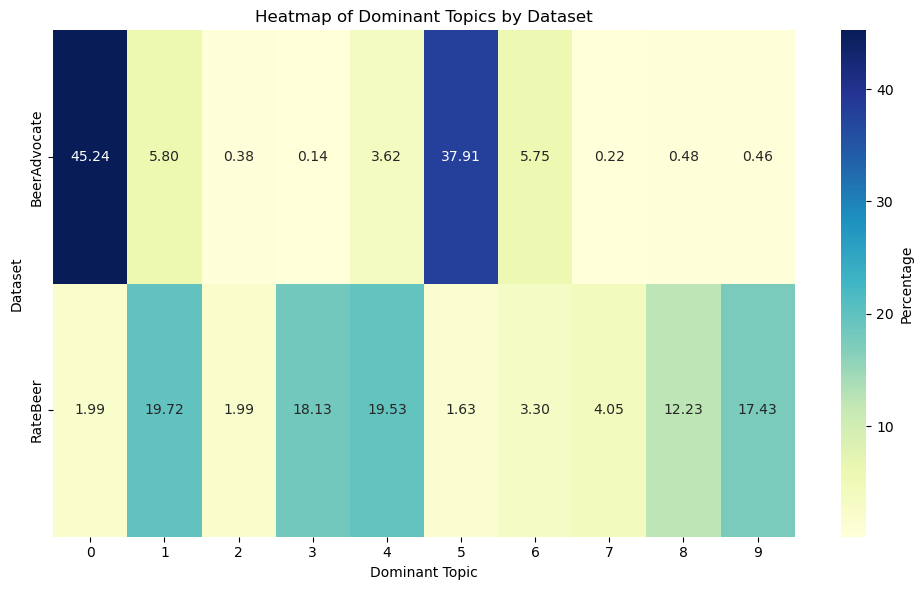

In [80]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap((topic_distribution / topic_distribution.loc['BeerAdvocate'].sum() * 100).round(2), annot=True, cmap="YlGnBu", cbar_kws={'label': 'Percentage'}, fmt='.2f')
plt.title("Heatmap of Dominant Topics by Dataset")
plt.xlabel("Dominant Topic")
plt.ylabel("Dataset")
plt.tight_layout()
plt.show()

## **Analysis of LDA Results**

#### **Overview of Topic Distribution**

The distribution of topics between BeerAdvocate and RateBeer reviews reveals significant differences in the focus and themes of each platform:

| **Dominant Topic** |   0   |   1   |  2  |  3  |   4  |   5  |  6  |  7  |   8   |   9   |
|--------------------|-------|-------|-----|-----|------|------|-----|-----|-------|-------|
| **BeerAdvocate**   | 4524  | 580   | 38  | 14  | 361  | 3793 | 575 | 22  | 47    | 46    |
| **RateBeer**       | 199   | 1972  |199  |1815 |1954  |163   |330  |403  |1222   |1743   |

#### Key Observations:
- BeerAdvocate topics are **heavily concentrated** in Topics 0, 5, and 1 and 6, with little presence in other topics.
- RateBeer topics are **more evenly distributed**, dominating Topics 1, 3, 4, 7, 8, and 9.

This distribution indicates that BeerAdvocate reviews tend to focus on a **narrower range of thematic categories**, while RateBeer covers a **broader spectrum of beer-related themes**.

---

### **Interpretation of Topics**

Below is an interpretation of each topic based on its top words:

#### **Topic 0 (BeerAdvocate-heavy)**:
- **Top Words**: "quot", "nose", "ale", "smell", "glass", "coffee", "lace", "brew", "leave", "mouthfeel"
- **Interpretation**: Focus on sensory descriptors like aroma ("nose", "smell") and beer appearance in the glass ("lace"). It reflects a traditional beer review style with attention to details like "mouthfeel" and "coffee" notes.

#### **Topic 1 (RateBeer-heavy)**:
- **Top Words**: "lager", "pale", "bad", "corn", "yellow", "nose", "drink", "gold", "pretty"
- **Interpretation**: Discusses lagers, pale beers, and simpler styles (e.g., "corn", "bad"). Highlights RateBeer’s tendency to cover mainstream or lighter beer styles, sometimes critically.

#### **Topic 2 (RateBeer)**:
- **Top Words**: "appearance", "amp", "ounce", "lacing", "nose", "smell", "mouthfeel", "overall"
- **Interpretation**: A structured rating approach focusing on "appearance", "overall" impressions, and sensory details like "smell". Indicates a methodical review style prevalent on RateBeer.

#### **Topic 3 (RateBeer)**:
- **Top Words**: "small", "nose", "pale", "hazy", "yellow", "grain", "citrus"
- **Interpretation**: Mentions of "hazy", "citrus", and "grain" suggest a focus on modern craft beer trends, particularly hazy pale ales.

#### **Topic 4 (RateBeer)**:
- **Top Words**: "yeast", "spice", "citrus", "wheat", "apple", "spicy", "banana"
- **Interpretation**: Notes common in Belgian-style beers, wheat beers, or more complex fruity/spicy profiles. Highlights RateBeer’s ability to capture a broader stylistic range.

#### **Topic 5 (BeerAdvocate-heavy)**:
- **Top Words**: "smell", "glass", "lacing", "finger", "overall", "drink", "great", "mouthfeel"
- **Interpretation**: A structured sensory topic focusing on beer appearance and aroma. Indicates BeerAdvocate’s focus on the visual and aromatic experience.

#### **Topic 6 (Mostly BeerAdvocate)**:
- **Top Words**: "coffee", "nose", "pretty", "feel", "mouth", "great"
- **Interpretation**: Reflects reviews of stouts, porters, or darker beers with coffee flavors. Another sensory-heavy topic focused on aroma and flavor.

#### **Topic 7 (RateBeer)**:
- **Top Words**: "smell", "brewpub", "tap", "rate", "thank", "Beer Buddy", "rate_Beer"
- **Interpretation**: References to "brewpub" and "tap" suggest discussion of drinking environments. Mentions of "Beer Buddy" and "rate_Beer" indicate a focus on tools/platform-specific experiences.

#### **Topic 8 (RateBeer)**:
- **Top Words**: "Taste", "Aroma", "coffee", "citrus", "roasted", "hazy", "Bottle"
- **Interpretation**: Combines descriptors like "citrus" and "roasted coffee", highlighting RateBeer’s diverse coverage of styles.

#### **Topic 9 (RateBeer)**:
- **Top Words**: "flavour", "colour", "malty", "Bottle", "hoppy", "yellow", "pale"
- **Interpretation**: Reflects a more global lexicon with British spellings ("flavour", "colour"). Covers a range of flavor profiles, indicating RateBeer’s international audience and stylistic breadth.

---

### **Insights for New Users**

Based on the results, here’s what each platform offers:

#### **BeerAdvocate**:
- **Themes**: Focus on aroma, appearance, and structured sensory details.
- **Strengths**: Classic beer rating style with detailed visual and aromatic evaluations.
- **Recommendation**: Best for users who value traditional beer reviews emphasizing sensory descriptions and aesthetics.

#### **RateBeer**:
- **Themes**: Broad coverage of beer styles, environments, and modern trends.
- **Strengths**: Includes craft styles (hazy, fruity, spicy), drinking environments, and global flavor profiles.
- **Recommendation**: Ideal for users seeking diverse beer styles, brewery experiences, and a global perspective.

---

### **Conclusion**

This analysis highlights distinct thematic focuses on each platform:
- **BeerAdvocate**: Detailed sensory reviews and visual descriptions dominate.
- **RateBeer**: Broader, trendier, and more global in its beer coverage.

By understanding these differences, new users can choose the platform that aligns with their preferences and beer interests.
